<span style="color:deeppink; font-size:35px;"><b>Figure R3</b></span>

Maps showing the (a,b) OLR anomalies and 500 hPa winds and (c,d) total rainfall and 850 hPa wind anomalies, for (top) 1-10 December 2024, and (bottom) 23-29 December 2024. The 1-10 December matches the time when the MJO was in Phase 5 and 23-29 December matches the time when the MJO was in Phase 6.  

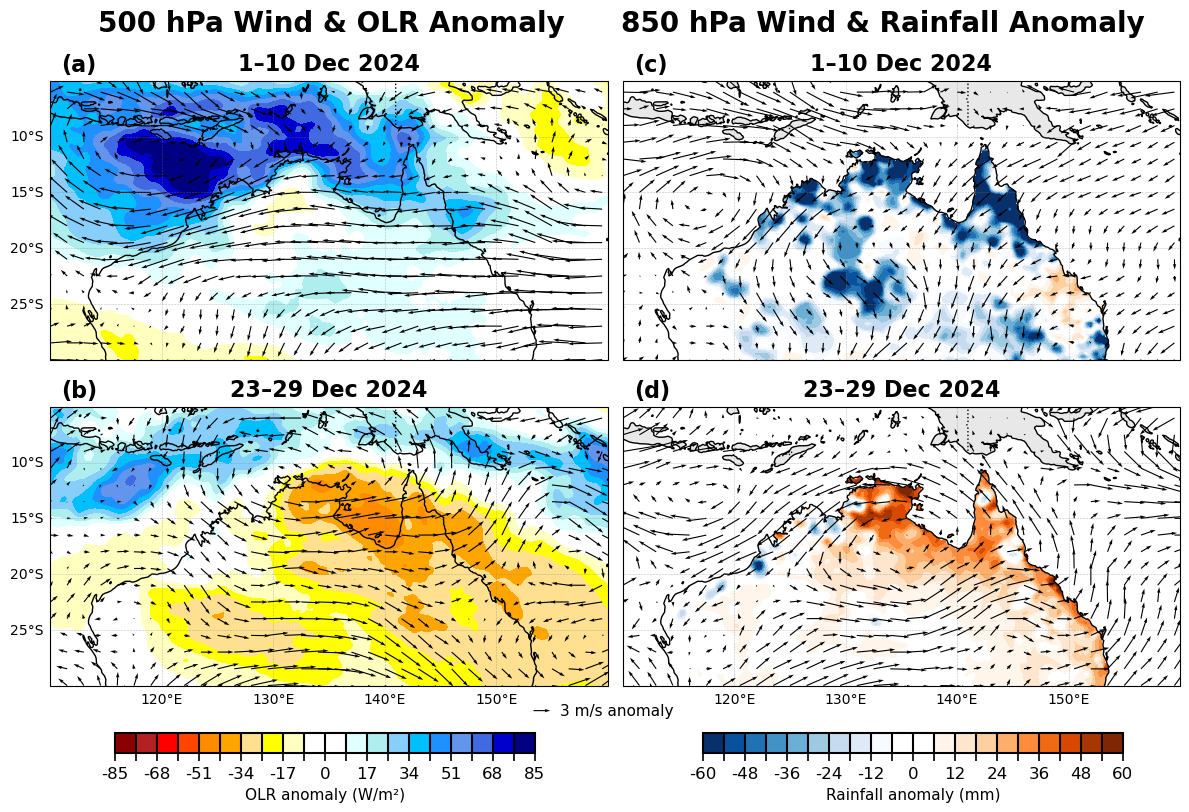

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm
import warnings
warnings.filterwarnings("ignore")

# =====================================================
# FILE PATHS
# =====================================================
base_dir = "/"
base_u500 = base_dir + "/ERA5_U_V_all_press_levs/500hPa_dec_only/u/{year}/u500_era5_daily_{year}1201-{year}1231.nc"
base_v500 = base_dir + "/ERA5_U_V_all_press_levs/500hPa_dec_only/v/{year}/v500_era5_daily_{year}1201-{year}1231.nc"
base_olr = base_dir + "/ERA5_OLR/{year}/ttr_era5_daily_{year}1201-{year}1231.nc"

base_u850 = base_dir + "/ERA5_U850/{year}/u850_era5_daily_{year}1201-{year}1231.nc"
base_v850 = base_dir + "/ERA5_V850/{year}/v850_era5_daily_{year}1201-{year}1231.nc"
base_pr = "/agcd_v1_precip_total_r005_daily_{year}.nc"
mask_ds = xr.open_dataset("/aus_05_land_mask.nc")
land_mask = mask_ds["land"]

# =====================================================
# CONFIG
# =====================================================
clim_years = np.arange(1974, 2022)
target_year = 2024
periods = [
    ("2024-12-01", "2024-12-10", "1–10 Dec 2024"),
    ("2024-12-23", "2024-12-29", "23–29 Dec 2024")
]
extent = [110, 160, -30, -5]

# =====================================================
# FUNCTION FOR CLIMATOLOGY
# =====================================================
def compute_climatology(u_path, v_path, f_var, start, end, level="500hPa"):
    u_list, v_list, f_list = [], [], []
    for yr in clim_years:
        try:
            u = xr.open_dataset(u_path.format(year=yr))["u"].sel(time=slice(f"{yr}-{start[-5:]}", f"{yr}-{end[-5:]}")).mean("time")
            v = xr.open_dataset(v_path.format(year=yr))["v"].sel(time=slice(f"{yr}-{start[-5:]}", f"{yr}-{end[-5:]}")).mean("time")
            f = xr.open_dataset(f_var.format(year=yr))
            varname = "ttr" if "ttr" in f else "precip"
            if varname == "ttr":
                f = f[varname].sel(time=slice(f"{yr}-{start[-5:]}", f"{yr}-{end[-5:]}")).mean("time")
            else:
                f = f[varname].sel(time=slice(f"{yr}-{start[-5:]}", f"{yr}-{end[-5:]}")).sum("time")
            u_list.append(u); v_list.append(v); f_list.append(f)
        except Exception:
            continue
    return (xr.concat(u_list, "year").mean("year"),
            xr.concat(v_list, "year").mean("year"),
            xr.concat(f_list, "year").mean("year"))

# =====================================================
# FIGURE SETUP
# =====================================================
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

nrows, ncols = axes.shape

# =====================================================
# LOOP OVER PERIODS (TOP=1–10 Dec, BOTTOM=23–29 Dec)
# =====================================================
for row, (start, end, label) in enumerate(periods):

    # === 500 hPa OLR ANOMALY (LEFT COLUMN) ===
    u_2024 = xr.open_dataset(base_u500.format(year=target_year))["u"].sel(time=slice(start, end)).mean("time")
    v_2024 = xr.open_dataset(base_v500.format(year=target_year))["v"].sel(time=slice(start, end)).mean("time")
    olr_2024 = xr.open_dataset(base_olr.format(year=target_year))["ttr"].sel(time=slice(start, end)).mean("time")
    u_clim, v_clim, olr_clim = compute_climatology(base_u500, base_v500, base_olr, start, end)
    u_anom, v_anom, olr_anom = u_2024 - u_clim, v_2024 - v_clim, olr_2024 - olr_clim

    ax = axes[row, 0]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = gl.right_labels = False

    
    if row == len(periods) - 1:  
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False



    colors_olr = [
        "navy", "mediumblue", "royalblue", "cornflowerblue", "dodgerblue", "deepskyblue", "lightskyblue", "paleturquoise", "lightcyan",       
        "white", "white", 
        "#ffffbf", "yellow", "#fee090", "orange", "darkorange", "orangered", "red", "firebrick", "darkred"
    ]

    # === COLORBAR ===
    cmap_olr = mcolors.ListedColormap(colors_olr)
    vmin, vmax = -85, 85  
    levels_olr = np.linspace(vmin, vmax, len(colors_olr) + 1)


    cf = ax.contourf(
        olr_anom["longitude"], olr_anom["latitude"], olr_anom,
        levels=levels_olr, cmap=cmap_olr, extend="both", transform=ccrs.PlateCarree()
    )

    skip = 6
    q = ax.quiver(
        u_anom["longitude"][::skip], u_anom["latitude"][::skip],
        u_anom[::skip, ::skip], v_anom[::skip, ::skip],
        scale=100, width=0.002, transform=ccrs.PlateCarree(), color="k"
    )
    ax.set_title(f"{label}", fontsize=16, fontweight="bold", pad=8)

    # === 850 hPa RAINFALL ANOMALY (RIGHT COLUMN) ===
    u_2024 = xr.open_dataset(base_u850.format(year=target_year))["u"].sel(time=slice(start, end)).mean("time")
    v_2024 = xr.open_dataset(base_v850.format(year=target_year))["v"].sel(time=slice(start, end)).mean("time")
    pr_2024 = xr.open_dataset(base_pr.format(year=target_year))["precip"].sel(time=slice(start, end)).sum("time")
    u_clim, v_clim, pr_clim = compute_climatology(base_u850, base_v850, base_pr, start, end)
    u_anom, v_anom, pr_anom = u_2024 - u_clim, v_2024 - v_clim, (pr_2024 - pr_clim).where(land_mask)

    ax = axes[row, 1]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = gl.right_labels = False

    
    if ax == axes[row, 0]:
        gl.left_labels = True
        gl.right_labels = False
    else:
        gl.left_labels = False
        gl.right_labels = False

    
    if row == len(periods) - 1:  
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False


    
    colors_pr = [
        "#08306B", "#08519C", "#2171B5", "#4292C6", "#6BAED6",
        "#9ECAE1", "#C6DBEF", "#DEEBF7", "#F7FBFF",
        "white", "white",
        "#FFF5EB", "#FEE6CE", "#FDD0A2", "#FDAE6B", "#FD8D3C",
        "#F16913", "#D94801", "#A63603", "#7F2704"
    ][::-1]

    cmap_pr = mcolors.ListedColormap(colors_pr)
    levels_pr = np.linspace(-60, 60, len(colors_pr) + 1)
    norm_pr = BoundaryNorm(levels_pr, ncolors=cmap_pr.N)
    cf = ax.contourf(
        pr_anom["lon"], pr_anom["lat"], pr_anom,
        levels=levels_pr, cmap=cmap_pr, norm=norm_pr, extend="both", transform=ccrs.PlateCarree()
    )

    skip = 6
    q = ax.quiver(
        u_anom["longitude"][::skip], u_anom["latitude"][::skip],
        u_anom[::skip, ::skip], v_anom[::skip, ::skip],
        scale=100, width=0.002, color="k", transform=ccrs.PlateCarree()
    )
    ax.set_title(f"{label}", fontsize=16, fontweight="bold", pad=8)
    


# =====================================================
# COLOURBARS (BOTTOM SHARED)
# =====================================================
################################################################################################################
# Colourbar for olr
my_cmap1, my_norm1 = mpl.colors.from_levels_and_colors(levels_olr, colors_olr[::-1], extend='neither')
cbar_ax1 = fig.add_axes([0.1, 0.17, 0.35, 0.02])

cbar1 = mpl.colorbar.ColorbarBase(
    cbar_ax1, cmap=my_cmap1, norm=my_norm1,
    boundaries=levels_olr, orientation='horizontal',
    drawedges=True
)
ticks1 = np.arange(-85, 86, 1)
cbar1.set_ticks(ticks1)
cbar1.ax.set_xticklabels([f"{t:.0f}" for t in ticks1])
cbar1.set_label("OLR anomaly (W/m²)", fontsize=11)
cbar1.set_ticks(levels_olr)
cbar1.ax.tick_params(labelsize=12, length=12, width=1.2, direction='inout')
cbar1.outline.set_edgecolor('black')
cbar1.outline.set_linewidth(1.5)
cbar1.dividers.set_color('black')
cbar1.dividers.set_linewidth(1.5)


# Colourbar for pr
my_cmap2, my_norm2 = mpl.colors.from_levels_and_colors(levels_pr, colors_pr[::-1], extend='neither')
cbar_ax2 = fig.add_axes([0.59, 0.17, 0.35, 0.02])

cbar2 = mpl.colorbar.ColorbarBase(
    cbar_ax2, cmap=my_cmap2, norm=my_norm2,
    boundaries=levels_pr, orientation='horizontal',
    drawedges=True
)
ticks2 = np.arange(-60, 61, 12)
cbar2.set_ticks(ticks2)
cbar2.ax.set_xticklabels([f"{t:.0f}" for t in ticks2])
cbar2.set_label("Rainfall anomaly (mm)", fontsize=11)
cbar2.set_ticks(levels_pr)
cbar2.ax.tick_params(labelsize=12, length=12, width=1.2, direction='inout')
cbar2.outline.set_edgecolor('black')
cbar2.outline.set_linewidth(1.5)
cbar2.dividers.set_color('black')
cbar2.dividers.set_linewidth(1.5)


axes[-1, -1].quiverkey(
    q, X=-0.13, Y=-0.09, U=3,
    label='3 m/s anomaly', labelpos='E',
    coordinates='axes',
    fontproperties={'size': 11}
)



fig.text(0.28, 0.9, "500 hPa Wind & OLR Anomaly",
         ha='center', va='center', fontsize=20, fontweight='bold')

fig.text(0.74, 0.9, "850 hPa Wind & Rainfall Anomaly",
         ha='center', va='center', fontsize=20, fontweight='bold')



labels = [['(a)', '(b)'], ['(c)', '(d)']]  

for col in range(2):
    for row in range(2):
        ax = axes[row, col]
        ax.text(
            0.02, 1.1, labels[col][row],
            transform=ax.transAxes,
            fontsize=16, fontweight='bold',
            va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
        )



plt.subplots_adjust(hspace=-0.44) 
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()




<span style="color:deeppink; font-size:35px;"><b>Figure R4</b></span>

Mean upper-level (100-300 hPa) winds (weighted) using ERA5 for (a) 15–19 Jan 2025, (b) Nov 2024–Jan 2025. (c, d) Same as (a, b) but showing anomalies with respect to a 1974-2021 climatology. Please note the reference vector is 10 m/s in (a) – (c) and 3 m/s in (d).  

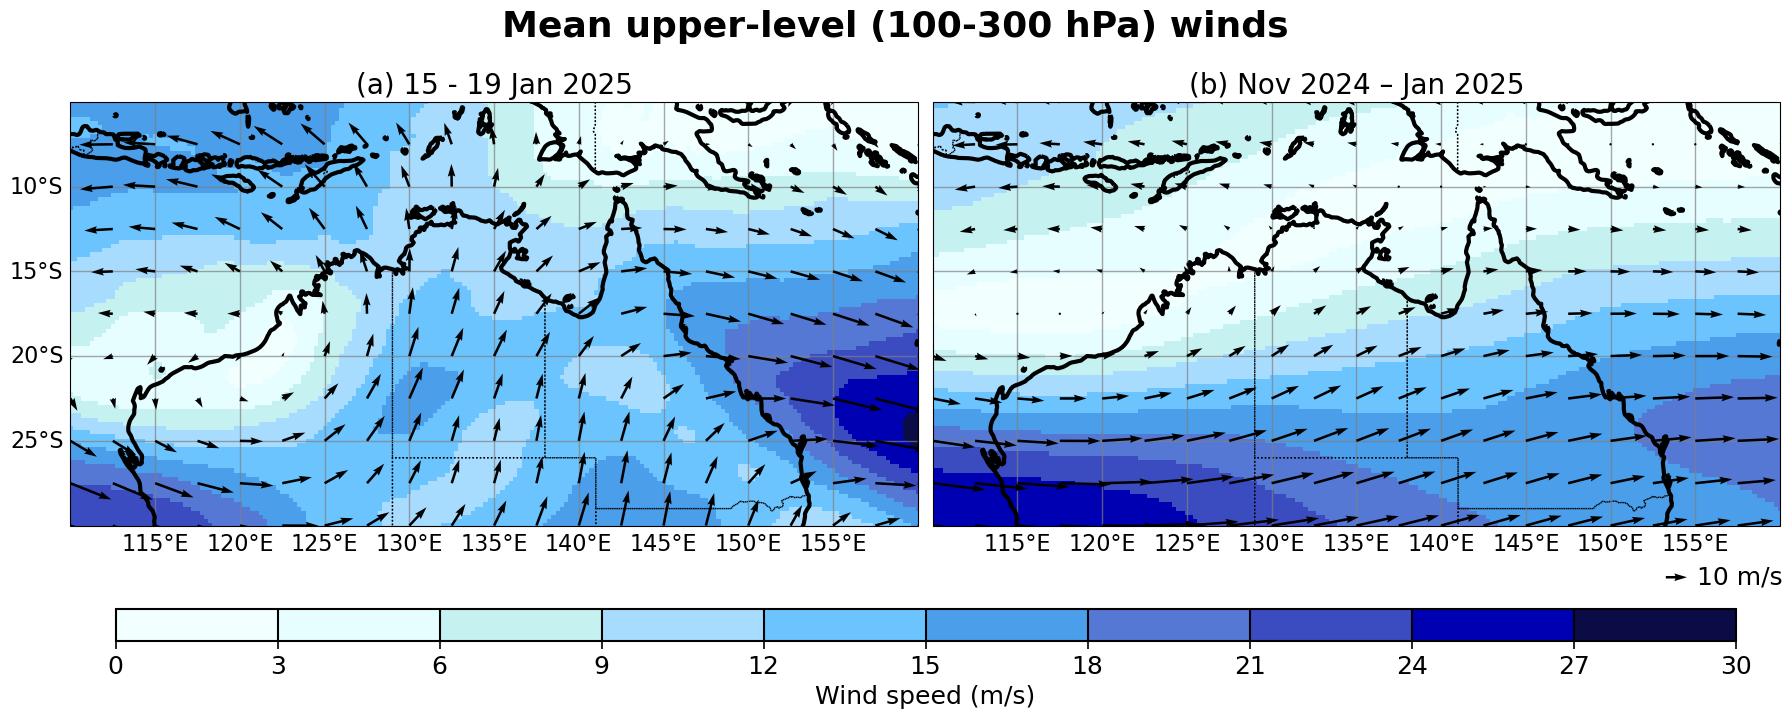

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
warnings.filterwarnings("ignore", message=".*tight_layout.*")

# === FILE PATHS ===
u_jan25 = "/uwnd/2025/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250101-20250131.nc"
v_jan25 = "/vwnd/2025/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250101-20250131.nc"

u_feb25 = "/uwnd/2025/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250201-20250228.nc" 
v_feb25 = "/vwnd/2025/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250201-20250228.nc"

u_nov24 = "/uwnd/2024/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241101-20241130.nc"
u_dec24 = "/uwnd/2024/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241201-20241231.nc"
v_nov24 = "/vwnd/2024/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241101-20241130.nc"
v_dec24 = "/vwnd/2024/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241201-20241231.nc"

# === LOAD DATA ===
def compute_mean_wind(u_files, v_files, time_slice=None):
    import xarray as xr
    import numpy as np

    pressure_weights = {300: 0.20, 200: 0.20, 150: 0.40, 100: 0.20}
    
    selected_levels = list(pressure_weights.keys())
    weights = xr.DataArray(
        [pressure_weights[p] for p in selected_levels],
        dims=["level"],
        coords={"level": selected_levels},
    )

    ds_u = xr.concat([xr.open_dataset(f) for f in u_files], dim="time")
    ds_v = xr.concat([xr.open_dataset(f) for f in v_files], dim="time")

    if time_slice:
        ds_u = ds_u.sel(time=slice(*time_slice))
        ds_v = ds_v.sel(time=slice(*time_slice))

    ds_u = ds_u.sel(level=selected_levels)
    ds_v = ds_v.sel(level=selected_levels)

    u_weighted = (ds_u["u"] * weights).sum(dim="level")
    v_weighted = (ds_v["v"] * weights).sum(dim="level")

    u_mean = u_weighted.mean(dim="time")
    v_mean = v_weighted.mean(dim="time")

    # --- Compute wind speed magnitude ---
    ws = np.sqrt(u_mean**2 + v_mean**2)

    return u_mean, v_mean, ws
    

# Subplot 1: Jan–Feb 2025
u1, v1, ws1 = compute_mean_wind(
    [u_jan25, u_feb25], [v_jan25, v_feb25],
    time_slice=("2025-01-15", "2025-01-19")
)

# Subplot 2: Nov–Jan (NDJ)
u2, v2, ws2 = compute_mean_wind(
    [u_nov24, u_dec24, u_jan25], [v_nov24, v_dec24, v_jan25]
)

colors = [
    "#F2FFFF",  
    "#E6FEFF",
    "#C6F1F1",
    "#A7DCFF",
    "#6CC4FF",
    "#4A9EEA",
    "#5578D4",
    "#3B4CC0",
    "#0000B3",
    "#0B0B45"
]


# Colourmap
cmap = ListedColormap(colors)
vmin, vmax = 0, 30
boundaries = np.linspace(vmin, vmax, len(colors) + 1)
norm = BoundaryNorm(boundaries, ncolors=cmap.N)

# === PLOTTING ===
fig, axes = plt.subplots(
    1, 2, figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)


titles = [
    "(a) 15 - 19 Jan 2025",
    "(b) Nov 2024 – Jan 2025"
]
datasets = [(u1, v1, ws1), (u2, v2, ws2)]


for i, (ax, (u, v, ws), title) in enumerate(zip(range(len(axes)), datasets, titles)):
    ax = axes[i]
    u, v, ws = datasets[i]
    title = titles[i]

    im = ws.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        shading="auto",
        add_colorbar=False,
    )
    step = 10
    q = ax.quiver(
        u.longitude[::step], u.latitude[::step],
        u[::step, ::step], v[::step, ::step],
        transform=ccrs.PlateCarree(),
        scale=400, color="black", width=0.003, zorder=4
    )
    ax.add_feature(cfeature.COASTLINE, linewidth=3, zorder=4)
    ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=4)
    ax.add_feature(cfeature.STATES, linestyle=":")
    ax.set_extent([110, 160, -30, -5], crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=20)

    gl = ax.gridlines(draw_labels=True, 
                      xlocs=np.arange(110, 160, 5),  
                      ylocs=np.arange(-45, -5, 5),  
                      linewidth=1, color='gray', alpha=0.7)  

    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = True
    
    if i == 0:
        gl.left_labels = True
    else:
        gl.left_labels = False
        
    gl.xlabel_style = {'size': 16} 
    gl.ylabel_style = {'size': 16}  



cbar_ax = fig.add_axes([0.067, 0.06, 0.9, 0.04]) 
colors = cmap(np.linspace(0, 1, len(boundaries) - 1))  
my_cmap, my_norm = mpl.colors.from_levels_and_colors(boundaries, colors, extend='neither')

cbar = mpl.colorbar.ColorbarBase(
    cbar_ax, cmap=my_cmap, norm=my_norm,
    boundaries=boundaries, orientation='horizontal',
    drawedges=True
)

cbar.set_label("Wind speed (m/s)", fontsize=18)
cbar.set_ticks(boundaries)
cbar.ax.tick_params(labelsize=18, length=12, width=1.2, direction='inout')
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1.5)
cbar.dividers.set_color('black')
cbar.dividers.set_linewidth(1.5)


ax.quiverkey(q, X=0.94, Y=0.14, U=10, label='10 m/s', labelpos='E',
             coordinates='figure', fontproperties={'size': 18})



fig.suptitle("Mean upper-level (100-300 hPa) winds", fontsize=26, fontweight="bold", y=0.85)


plt.tight_layout()
plt.show()




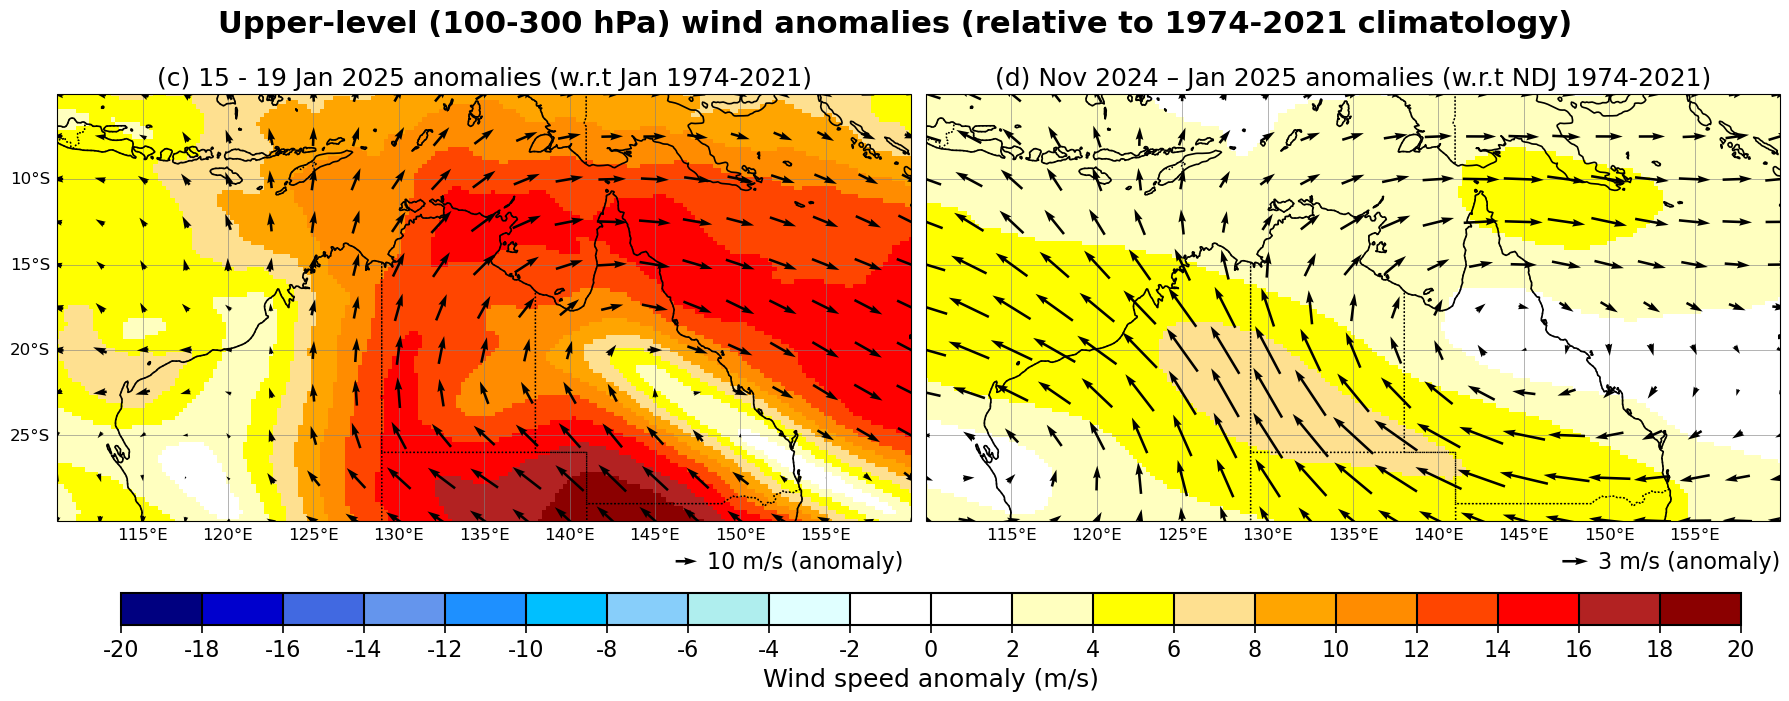

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import glob
import os
import warnings
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

# === FILE PATHS ===
u_jan25 = "/uwnd/2025/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250101-20250131.nc"
v_jan25 = "/vwnd/2025/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250101-20250131.nc"

u_feb25 = "/uwnd/2025/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250201-20250228.nc"
v_feb25 = "/vwnd/2025/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250201-20250228.nc"

u_nov24 = "/uwnd/2024/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241101-20241130.nc"
u_dec24 = "/uwnd/2024/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241201-20241231.nc"
v_nov24 = "/vwnd/2024/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241101-20241130.nc"
v_dec24 = "/vwnd/2024/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241201-20241231.nc"

pressure_weights = {300: 0.20, 200: 0.20, 150: 0.40, 100: 0.20}
selected_levels = list(pressure_weights.keys())
years_for_clim = list(range(1974, 2022))  

u_clim_template = "/{level}hPa/u/*/*u{level}_era5_daily_*.nc"
v_clim_template = "/{level}hPa/v/*/*v{level}_era5_daily_*.nc"

# ========== FUNCTIONS ==========
def weighted_level_mean(ds, varname="u", weights_map=pressure_weights):
    """
    ds: xarray Dataset with coordinate 'level' matching keys in weights_map
    returns: DataArray with level dimension summed out using provided weights
    """
    levels = list(weights_map.keys())
    w = xr.DataArray([weights_map[l] for l in levels], dims=["level"], coords={"level": levels})
    da = ds[varname].sel(level=levels)
    return (da * w).sum(dim="level")


def build_climatology(months, u_template=u_clim_template, v_template=v_clim_template, years=years_for_clim):
    """
    months: list/iterable of month integers (1-12). Example: [1] for January; [11,12,1] for NDJ.
    returns: u_clim_mean, v_clim_mean, ws_clim_mean as xarray DataArrays averaged over years+months
    """
    u_list = []
    v_list = []
    for level in selected_levels:
        u_pattern = u_template.format(level=level)
        v_pattern = v_template.format(level=level)
        u_files_all = sorted(glob.glob(u_pattern))
        v_files_all = sorted(glob.glob(v_pattern))

        def file_matches_months(fname):
            bn = os.path.basename(fname)

            import re
            m = re.search(r"(\d{6})", bn)
            if not m:
                return False
            yyyymm = m.group(1)
            month = int(yyyymm[4:6])
            year = int(yyyymm[0:4])
            return (month in months) and (year in years)

        u_files = [f for f in u_files_all if file_matches_months(f)]
        v_files = [f for f in v_files_all if file_matches_months(f)]

        if len(u_files) == 0 or len(v_files) == 0:
            warnings.warn(f"No climatology files found for level {level}hPa and months {months}. Pattern {u_pattern}")
            continue

        ds_u = xr.open_mfdataset(u_files, combine="by_coords", parallel=False)
        ds_v = xr.open_mfdataset(v_files, combine="by_coords", parallel=False)

        ds_u = ds_u.sel(time=ds_u.indexes["time"].month.isin(months))
        ds_v = ds_v.sel(time=ds_v.indexes["time"].month.isin(months))

        u_list.append(ds_u)
        v_list.append(ds_v)

    u_level_datasets = []
    v_level_datasets = []
    for ds_u, ds_v, level in zip(u_list, v_list, selected_levels):
        ds_u = ds_u.assign_coords(level=np.array([level]))
        ds_v = ds_v.assign_coords(level=np.array([level]))

        u_level_datasets.append(ds_u)
        v_level_datasets.append(ds_v)

    
    dsu_all = xr.concat(u_level_datasets, dim="level")
    dsv_all = xr.concat(v_level_datasets, dim="level")

    # Weighted pressure level mean 
    u_vert_mean = weighted_level_mean(dsu_all, varname="u", weights_map=pressure_weights)
    v_vert_mean = weighted_level_mean(dsv_all, varname="v", weights_map=pressure_weights)

    u_clim = u_vert_mean.mean(dim="time")
    v_clim = v_vert_mean.mean(dim="time")
    ws_clim = np.sqrt(u_clim**2 + v_clim**2)

    return u_clim, v_clim, ws_clim

# Computing climatologies
# January climatology (for Jan-15-19 anomaly)
u_clim_jan, v_clim_jan, ws_clim_jan = build_climatology([1])

# NDJ climatology (Nov, Dec, Jan) 
u_clim_ndj, v_clim_ndj, ws_clim_ndj = build_climatology([11, 12, 1])

# --- Function to compute weighted mean ---
def compute_mean_wind(u_files, v_files, time_slice=None):
    ds_u = xr.concat([xr.open_dataset(f) for f in u_files], dim="time")
    ds_v = xr.concat([xr.open_dataset(f) for f in v_files], dim="time")

    if time_slice:
        ds_u = ds_u.sel(time=slice(*time_slice))
        ds_v = ds_v.sel(time=slice(*time_slice))

    ds_u = ds_u.sel(level=selected_levels)
    ds_v = ds_v.sel(level=selected_levels)

    u_weighted = weighted_level_mean(ds_u, varname="u", weights_map=pressure_weights)
    v_weighted = weighted_level_mean(ds_v, varname="v", weights_map=pressure_weights)

    u_mean = u_weighted.mean(dim="time")
    v_mean = v_weighted.mean(dim="time")
    ws = np.sqrt(u_mean**2 + v_mean**2)

    return u_mean, v_mean, ws

# Subplot 1: Jan 15-19 2025 
u1, v1, ws1 = compute_mean_wind(
    [u_jan25, u_feb25], [v_jan25, v_feb25],
    time_slice=("2025-01-15", "2025-01-19")
)

# Subplot 2: NDJ (Nov 2024 - Jan 2025)
u2, v2, ws2 = compute_mean_wind(
    [u_nov24, u_dec24, u_jan25],
    [v_nov24, v_dec24, v_jan25]
)

# Anomalies
u1_anom = u1 - u_clim_jan
v1_anom = v1 - v_clim_jan
ws1_anom = np.sqrt(u1_anom**2 + v1_anom**2) 

u2_anom = u2 - u_clim_ndj
v2_anom = v2 - v_clim_ndj
ws2_anom = np.sqrt(u2_anom**2 + v2_anom**2)


# === PLOTTING ===
fig, axes = plt.subplots(
    1, 2, figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

titles = [
    "(c) 15 - 19 Jan 2025 anomalies (w.r.t Jan 1974-2021)",
    "(d) Nov 2024 – Jan 2025 anomalies (w.r.t NDJ 1974-2021)"
]
datasets = [(u1_anom, v1_anom, ws1_anom, u_clim_jan, v_clim_jan), (u2_anom, v2_anom, ws2_anom, u_clim_ndj, v_clim_ndj)]

colors = [
    "navy", "mediumblue", "royalblue", "cornflowerblue", "dodgerblue", "deepskyblue", "lightskyblue", "paleturquoise", "lightcyan",       
    "white", "white", 
    "#ffffbf", "yellow", "#fee090", "orange", "darkorange", "orangered", "red", "firebrick", "darkred"
]

# === COLORBAR ===
cmap = mcolors.ListedColormap(colors)
vmin, vmax = -20, 20
levels = np.linspace(vmin, vmax, len(colors) + 1)
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)


for i, ax in enumerate(axes):
    u_an, v_an, ws_an, u_clim_ref, v_clim_ref = datasets[i]

    im = ws_an.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        shading="auto",
        add_colorbar=False,
    )


    step = 10

    if i == 0:
        scale_value = 400
        ref_speed = 10  # m/s reference for first subplot
        qkey_pos = (0.39, 0.14)
    elif i == 1:
        scale_value = 100
        ref_speed = 3   # m/s reference for second subplot
        qkey_pos = (0.885, 0.14)
    else:
        scale_value = 400
        ref_speed = 10
        qkey_pos = (0.39, 0.14)


    q = ax.quiver(
        u_an.longitude[::step], u_an.latitude[::step],
        u_an[::step, ::step], v_an[::step, ::step],
        transform=ccrs.PlateCarree(),
        scale=scale_value, width=0.003, zorder=4, pivot="mid", minlength=0.1
    )

    ax.quiverkey(
        q, X=qkey_pos[0], Y=qkey_pos[1], U=ref_speed,
        label=f'{ref_speed} m/s (anomaly)',
        labelpos='E', coordinates='figure',
        fontproperties={'size': 16}
    )
    

    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=4)
    ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=4)
    ax.add_feature(cfeature.STATES, linestyle=":")
    ax.set_extent([110, 160, -30, -5], crs=ccrs.PlateCarree())
    ax.set_title(titles[i], fontsize=18)

    gl = ax.gridlines(draw_labels=True,
                      xlocs=np.arange(110, 160, 5),
                      ylocs=np.arange(-45, -5, 5),
                      linewidth=0.6, color='gray', alpha=0.7)
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = (i == 0)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}



# Colourbar
cbaxes = fig.add_axes([0.07, 0.06, 0.9, 0.04])

my_cmap, my_norm = mpl.colors.from_levels_and_colors(levels, colors, extend='neither')

cbar = mpl.colorbar.ColorbarBase(
    cbaxes, cmap=my_cmap, norm=my_norm,
    boundaries=levels, orientation='horizontal',
    drawedges=True
)

ticks = np.arange(vmin, vmax+1, 1)
cbar.set_ticks(ticks)
cbar.ax.set_xticklabels([f"{t:.0f}" for t in ticks])
cbar.set_label("Wind speed anomaly (m/s)", fontsize=18)
cbar.set_ticks(levels)
cbar.ax.tick_params(labelsize=16, length=12, width=1.2, direction='inout')
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1.5)
cbar.dividers.set_color('black')
cbar.dividers.set_linewidth(1.5)



fig.suptitle("Upper-level (100-300 hPa) wind anomalies (relative to 1974-2021 climatology)", fontsize=22, fontweight="bold", y=0.83)
plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.show()





<span style="color:deeppink; font-size:35px;"><b>Figure R6</b></span>

(a) NDJ 2024/25 anomalous upper-level (100-300 hPa weighted) winds (vectors) and wind speed (shading) relative to a 1974 to 2024 climatology using ERA5 (b) as in (a), but for the composite of La Niña years (from 1974 to 2024).

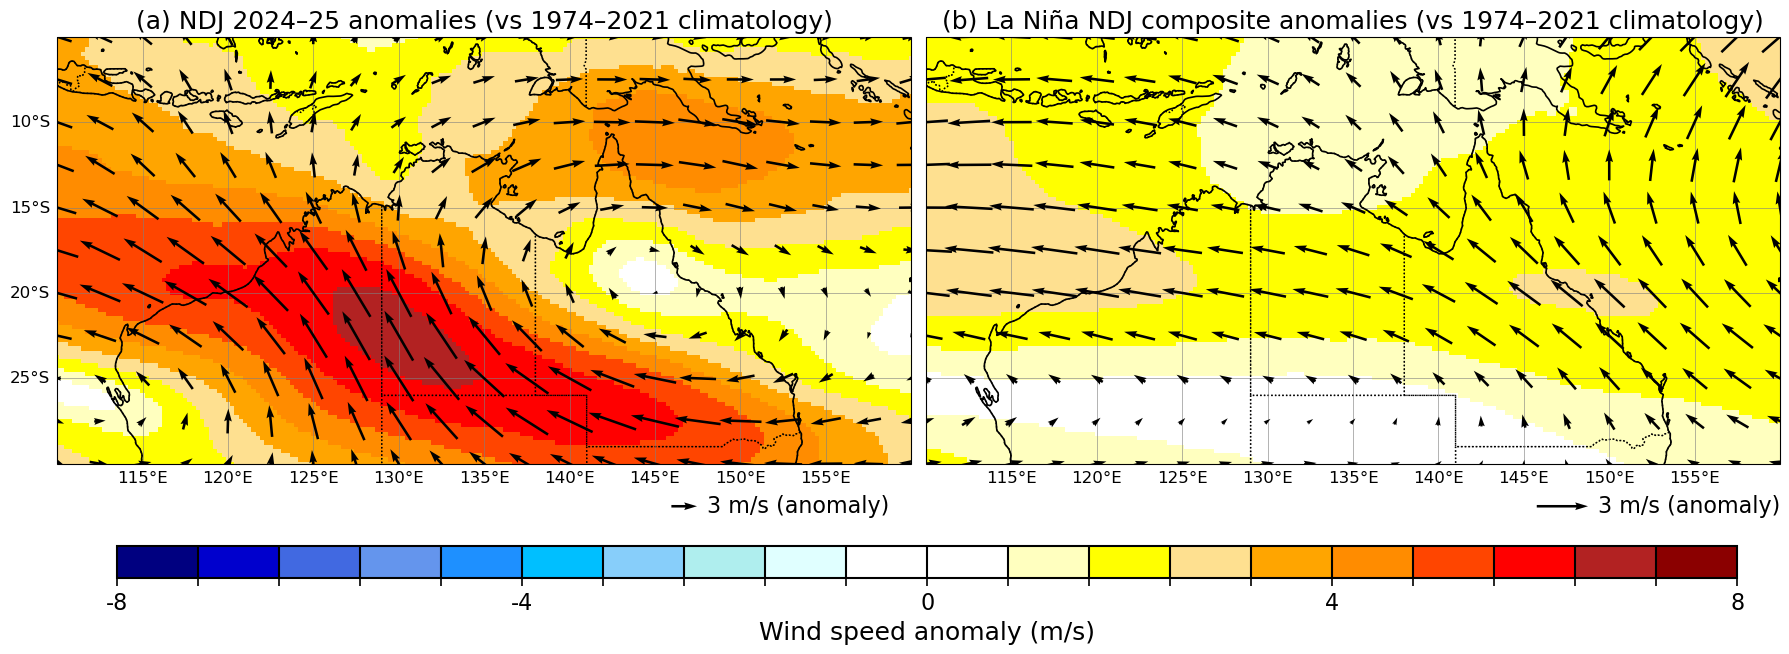

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import glob, os, warnings, re, matplotlib as mpl
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

# ==============================
# FILE PATHS CONFIGURATION
# ==============================
pressure_weights = {300: 0.20, 200: 0.20, 150: 0.40, 100: 0.20}
selected_levels = list(pressure_weights.keys())

years_for_clim = list(range(1974, 2022))
la_nina_years = [1998, 1999, 2000, 2007, 2008, 2010, 2011, 2017, 2020, 2021, 2022, 2024]


u_clim_template = "/ERA5_U_V_all_press_levs/{level}hPa/u/*/*u{level}_era5_daily_*.nc"
v_clim_template = "/ERA5_U_V_all_press_levs/{level}hPa/v/*/*v{level}_era5_daily_*.nc"

# NDJ 2024–25 files 
u_jan25 = "/uwnd/2025/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250101-20250131.nc"
v_jan25 = "/vwnd/2025/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20250101-20250131.nc"

u_nov24 = "/uwnd/2024/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241101-20241130.nc"
u_dec24 = "/uwnd/2024/u_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241201-20241231.nc"
v_nov24 = "/vwnd/2024/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241101-20241130.nc"
v_dec24 = "/vwnd/2024/v_press_levs_300plus_5S_45S_110E_160E_era5_daily_20241201-20241231.nc"

# ============================================================
# Functions 
# ============================================================
def weighted_level_mean(ds, varname="u"):
    levels = list(pressure_weights.keys())
    w = xr.DataArray([pressure_weights[l] for l in levels], dims=["level"], coords={"level": levels})
    return (ds[varname].sel(level=levels) * w).sum(dim="level")

def build_climatology(months, years):
    """Compute mean climatology for given months and years."""
    u_list, v_list = [], []
    for level in selected_levels:
        u_files = sorted(glob.glob(u_clim_template.format(level=level)))
        v_files = sorted(glob.glob(v_clim_template.format(level=level)))

        def match_month_year(fname):
            m = re.search(r"(\d{6})", os.path.basename(fname))
            if not m: return False
            year, month = int(m.group(1)[:4]), int(m.group(1)[4:])
            return (month in months) and (year in years)

        u_sel = [f for f in u_files if match_month_year(f)]
        v_sel = [f for f in v_files if match_month_year(f)]
        if not u_sel or not v_sel: continue

        ds_u = xr.open_mfdataset(u_sel, combine="by_coords")
        ds_v = xr.open_mfdataset(v_sel, combine="by_coords")
        ds_u = ds_u.sel(time=ds_u.indexes["time"].month.isin(months))
        ds_v = ds_v.sel(time=ds_v.indexes["time"].month.isin(months))
        ds_u = ds_u.assign_coords(level=np.array([level]))
        ds_v = ds_v.assign_coords(level=np.array([level]))
        u_list.append(ds_u); v_list.append(ds_v)

    u_all = xr.concat(u_list, dim="level")
    v_all = xr.concat(v_list, dim="level")
    u_mean = weighted_level_mean(u_all, "u").mean("time")
    v_mean = weighted_level_mean(v_all, "v").mean("time")
    ws_mean = np.sqrt(u_mean**2 + v_mean**2)
    return u_mean, v_mean, ws_mean

def compute_mean_wind(u_files, v_files):
    ds_u = xr.concat([xr.open_dataset(f) for f in u_files], dim="time")
    ds_v = xr.concat([xr.open_dataset(f) for f in v_files], dim="time")
    ds_u = ds_u.sel(level=selected_levels)
    ds_v = ds_v.sel(level=selected_levels)
    u_w = weighted_level_mean(ds_u, "u").mean("time")
    v_w = weighted_level_mean(ds_v, "v").mean("time")
    ws = np.sqrt(u_w**2 + v_w**2)
    return u_w, v_w, ws


# ============================================================
# Climatology (NDJ 1974–2021)
# ============================================================
u_clim, v_clim, ws_clim = build_climatology([11,12,1], years_for_clim)

# ============================================================
# NDJ 2024/25 mean
# ============================================================
u_ndj25, v_ndj25, ws_ndj25 = compute_mean_wind([u_nov24, u_dec24, u_jan25],
                                               [v_nov24, v_dec24, v_jan25])

# ============================================================
# La Niña NDJ composite mean (NDJ months in la_nina_years)
# ============================================================
u_lanina, v_lanina, ws_lanina = build_climatology([11,12,1], la_nina_years)

# ============================================================
# Anomalies
# ============================================================
u_ndj25_anom = u_ndj25 - u_clim
v_ndj25_anom = v_ndj25 - v_clim
ws_ndj25_anom = np.sqrt(u_ndj25_anom**2 + v_ndj25_anom**2)

u_lanina_anom = u_lanina - u_clim
v_lanina_anom = v_lanina - v_clim
ws_lanina_anom = np.sqrt(u_lanina_anom**2 + v_lanina_anom**2)

# ============================================================
# Plotting 
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

titles = [
    "(a) NDJ 2024–25 anomalies (vs 1974–2021 climatology)",
    "(b) La Niña NDJ composite anomalies (vs 1974–2021 climatology)"
]
datasets = [
    (u_ndj25_anom, v_ndj25_anom, ws_ndj25_anom),
    (u_lanina_anom, v_lanina_anom, ws_lanina_anom)
]

colors = [
    "navy", "mediumblue", "royalblue", "cornflowerblue", "dodgerblue", "deepskyblue", "lightskyblue", "paleturquoise", "lightcyan",       
    "white", "white", 
    "#ffffbf", "yellow", "#fee090", "orange", "darkorange", "orangered", "red", "firebrick", "darkred"
]

cmap = mcolors.ListedColormap(colors)
vmin, vmax = -8, 8
levels = np.linspace(vmin, vmax, len(colors)+1)
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

for i, ax in enumerate(axes):
    u_an, v_an, ws_an = datasets[i]
    ws_an.plot.pcolormesh(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
                          shading="auto", add_colorbar=False)

    
    step = 10

    if i == 0:
        scale_value = 100
        ref_speed = 3  # m/s reference for first subplot
        qkey_pos = (0.39, 0.22)
    elif i == 1:
        scale_value = 50
        ref_speed = 3  # m/s reference for second subplot
        qkey_pos = (0.885, 0.22)
    else:
        scale_value = 100
        ref_speed = 3
        qkey_pos = (0.39, 0.22)


    q = ax.quiver(
        u_an.longitude[::step], u_an.latitude[::step],
        u_an[::step, ::step], v_an[::step, ::step],
        transform=ccrs.PlateCarree(),
        scale=scale_value, width=0.003, zorder=4, pivot="mid", minlength=0.1
    )

    ax.quiverkey(
        q, X=qkey_pos[0], Y=qkey_pos[1], U=ref_speed,
        label=f'{ref_speed} m/s (anomaly)',
        labelpos='E', coordinates='figure',
        fontproperties={'size': 16}
    )
    

    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=4)
    ax.add_feature(cfeature.BORDERS, linestyle=":", zorder=4)
    ax.add_feature(cfeature.STATES, linestyle=":")
    ax.set_extent([110, 160, -30, -5], crs=ccrs.PlateCarree())
    ax.set_title(titles[i], fontsize=18)

    gl = ax.gridlines(draw_labels=True,
                      xlocs=np.arange(110, 160, 5),
                      ylocs=np.arange(-45, -5, 5),
                      linewidth=0.6, color='gray', alpha=0.7)
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = (i == 0)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}




# Colourbar
cbaxes = fig.add_axes([0.068, 0.13, 0.9, 0.04])

my_cmap, my_norm = mpl.colors.from_levels_and_colors(levels, colors, extend='neither')

cbar = mpl.colorbar.ColorbarBase(
    cbaxes, cmap=my_cmap, norm=my_norm,
    boundaries=levels, orientation='horizontal',
    drawedges=True
)

ticks = np.arange(vmin, vmax+1, 1)
cbar.set_ticks(ticks)
cbar.ax.set_xticklabels([f"{t:.0f}" for t in ticks])
cbar.set_label("Wind speed anomaly (m/s)", fontsize=18)
cbar.set_ticks(levels)
cbar.ax.tick_params(labelsize=16, length=12, width=1.2, direction='inout')
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1.5)
cbar.dividers.set_color('black')
cbar.dividers.set_linewidth(1.5)


plt.subplots_adjust(hspace=-0.44) 
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()





<span style="color:deeppink; font-size:35px;"><b>Figure R7</b></span>

Area-averaged 200 hPa winds over the Top End region of northern Australia (10.8°S-15.5°S, 129°E-137°E). This is based on ERA5 winds, as opposed to sounding data used in Figure 4 of the study.  

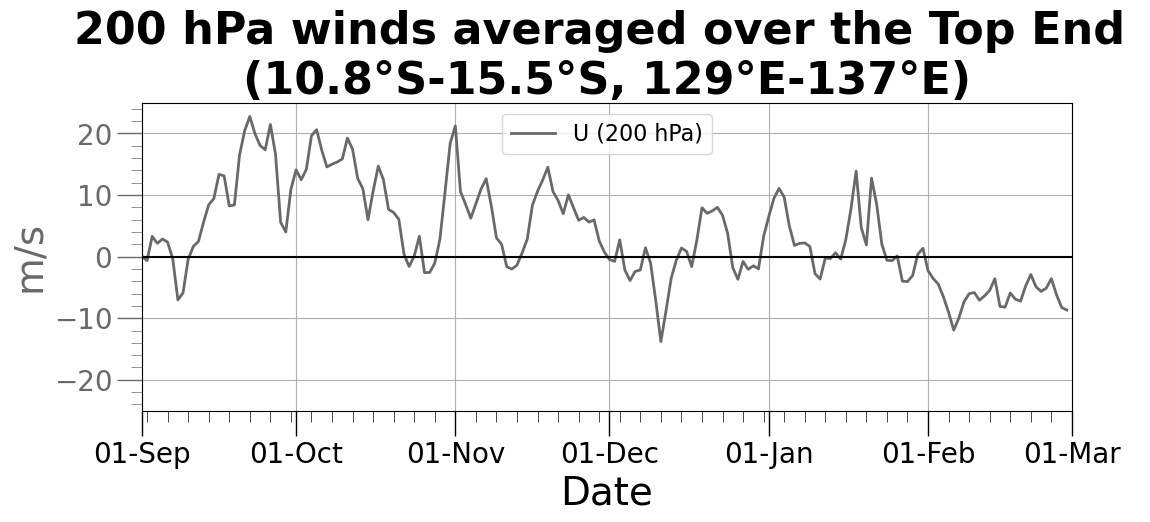

In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import calendar
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import calendar


year = 2024
start_year = 2024
end_year = 2025

start_date, end_date = f"{year}-09-01", f"{year+1}-04-30"

# Define Top End region
lat_bounds = slice(-10.8, -15.5)   # 10.8–15.5°S
lon_bounds = slice(129, 137)   # 129–137°E

# === ERA5 WIND FILES ===
files_2024 = [
    f"/2024/u_all_press_levs_5S_15S_110E_140E_era5_daily_{year:04d}{month:02d}01-{year:04d}{month:02d}{calendar.monthrange(year, month)[1]:02d}.nc"
    for year in [2024] for month in range(1, 13)
]

files_2025 = [
    f"/2025/u_all_press_levs_5S_15S_110E_140E_era5_daily_2025{month:02d}01-2025{month:02d}{calendar.monthrange(2025, month)[1]:02d}.nc"
    for month in range(1, 3) 
]


ds_winds = xr.open_mfdataset(files_2024 + files_2025, combine="by_coords")
ds_winds = ds_winds.sel(latitude=lat_bounds, longitude=lon_bounds, time=slice(start_date, end_date))

uwnd_200 = ds_winds["u"].sel(level=200).mean(dim=("latitude","longitude"))

################################################ Plotting ################################################
fig, axs = plt.subplots(figsize=(12, 4), sharex=True)
axs.set_ylabel("m/s", color="dimgrey", fontsize=28)
axs.set_xlabel("Date", fontsize=28)
axs.tick_params(axis='y', labelcolor="dimgrey", labelsize=20)
axs.tick_params(axis='x', labelsize=20)

axs.set_ylim(-25, 25)


# U200
axs.plot(uwnd_200.time, uwnd_200, label="U (200 hPa)", color="dimgrey", linewidth=2)
axs.axhline(0, color='black', linestyle='-', linewidth=1.5)

axs.grid()

plt.tick_params(axis='both', labelsize=20) 

xticks = pd.date_range(start="2024-09-01", end="2025-03-25", freq='1MS')
axs.set_xticks(xticks, [date.strftime('%d-%b') for date in xticks], rotation=360, fontsize=20)
axs.minorticks_on()
axs.tick_params(axis='both', which='major', length=18, width=1)  
axs.tick_params(axis='both', which='minor', length=8, width=0.5) 
axs.xaxis.set_minor_locator(ticker.MultipleLocator(4)) 
axs.set_xlim(xticks[0], xticks[-1])
axs.set_title("200 hPa winds averaged over the Top End \n(10.8°S-15.5°S, 129°E-137°E)", fontweight="bold", fontsize=32)


lines1, labels1 = axs.get_legend_handles_labels()

axs.legend(lines1, labels1, loc="upper center", fontsize=16, ncols=3)
axs.tick_params(axis='both', labelsize=20)
axs.tick_params(axis='y', which='major', length=18, width=1, color="dimgrey") 
axs.tick_params(axis='y', which='minor', length=8, width=0.5, color="dimgrey") 

plt.show()



<span style="color:deeppink; font-size:35px;"><b>Figure R8</b></span>

D96 onset based on using ERA5 weighted lower- and upper-level winds. The onset date here is 6 February, compared to the 7 February based on sounding observations.  

ERA5 Drosdowsky ASM onset (2024–25): 2025-02-06 00:00:00


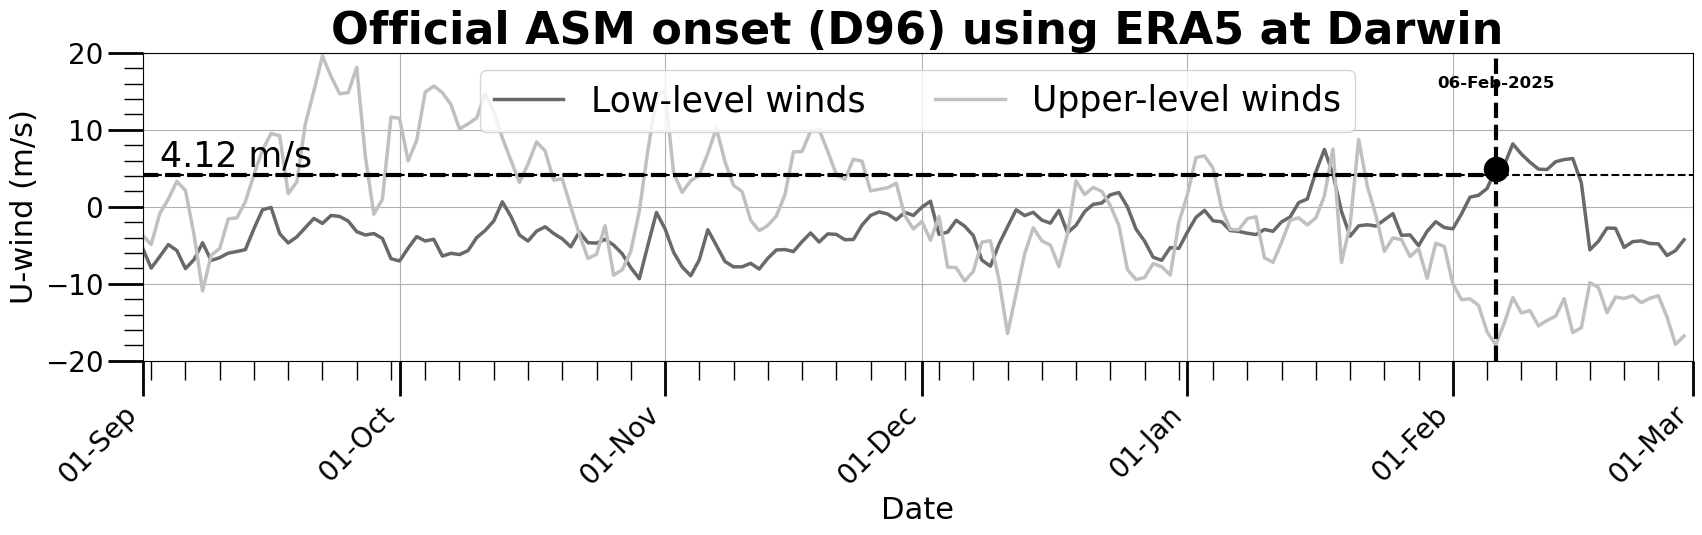

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import calendar


start_year = 2024
end_year = 2025
lat_sel, lon_sel = -12.4239, 130.8925  # Darwin
threshold=4.12

pressure_weights = {
    'low': {1000: 0.1, 900: 0.15, 850: 0.12, 775: 0.15, 700: 0.13, 600: 0.1, 600: 0.15, 500: 0.1},
    'upper': {200: 0.25, 150: 0.5, 100: 0.25}
}


# Function to calculate weighted mean U
def weighted_mean_u(ds, pressure_level):
    weights = pressure_weights[pressure_level]
    ds_filtered = ds.sel(level=list(weights.keys()))
    weighted_u = (ds_filtered.u * xr.DataArray([weights[p] for p in ds_filtered.level.values], dims="level")).sum(dim="level")
    return weighted_u

# === ERA5 files ===
files_2024 = [
    f"/2024/u_all_press_levs_5S_15S_110E_140E_era5_daily_{year:04d}{month:02d}01-{year:04d}{month:02d}{calendar.monthrange(year, month)[1]:02d}.nc"
    for year in [2024] for month in range(1, 13)
]

files_2025 = [
    f"/2025/u_all_press_levs_5S_15S_110E_140E_era5_daily_2025{month:02d}01-2025{month:02d}{calendar.monthrange(2025, month)[1]:02d}.nc"
    for month in range(1, 3)  
]

ds = xr.open_mfdataset(files_2024 + files_2025, combine="by_coords")

# Select Darwin 
ds_darwin = ds.sel(latitude=lat_sel, longitude=lon_sel, method="nearest")

# Weighted means
low_level_mean = weighted_mean_u(ds_darwin, "low")
upper_level_mean = weighted_mean_u(ds_darwin, "upper")


df = xr.merge([
    low_level_mean.rename("U_weighted_mean_low"),
    upper_level_mean.rename("U_weighted_mean_upper")
]).to_dataframe().reset_index()
df["Date"] = pd.to_datetime(df["time"])

df_period = df[(df["Date"] >= "2024-09-01") & (df["Date"] <= "2025-03-01")]

# Function to find onset
def find_monsoon_onset(df):
    onset_date = None
    for i in range(1, len(df)):
        if (df["U_weighted_mean_low"].iloc[i] > 4.12 and
            df["U_weighted_mean_low"].iloc[i-1] > 4.12 and
            df["U_weighted_mean_upper"].iloc[i] < 0 and
            df["U_weighted_mean_upper"].iloc[i-1] < 0):
            onset_date = df["Date"].iloc[i-1]
            break
    return onset_date


onset_24_25 = find_monsoon_onset(df_period)
print(f"ERA5 Drosdowsky ASM onset (2024–25): {onset_24_25}")

# === Plotting ===
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(df_period["Date"], df_period["U_weighted_mean_low"], label="Low-level winds", color="dimgrey", linewidth=2.5)
ax.plot(df_period["Date"], df_period["U_weighted_mean_upper"], label="Upper-level winds", color="silver", linewidth=2.5)

ax.set_ylabel("U-wind (m/s)", fontsize=22)
ax.set_xlabel("Date", fontsize=22)
ax.set_title("Official ASM onset (D96) using ERA5 at Darwin", fontsize=32, fontweight='bold') 

ax.legend(fontsize=25, ncols=2, loc='upper center')

ax.axhline(4.12, color='black', linestyle='--', linewidth=1.5)

ax.set_xlim(df_period["Date"].min(), df_period["Date"].max())
ax.tick_params(axis='y', size=14)
ax.tick_params(axis='both', labelsize=20)
ax.set_ylim(-20, 20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
start_date, end_date = f"{start_year}-09-01", f"{start_year+1}-04-30"
ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(f"{start_year+1}-03-01"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
ax.grid(True)


ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=25, width=2) 
ax.tick_params(axis='both', which='minor', length=14, width=1) 
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))


if onset_24_25 is not None:
    ax.axvline(onset_24_25, color='black', linestyle='--', linewidth=3)
    ax.text(onset_24_25, 15, onset_24_25.strftime('%d-%b-%Y'),
            verticalalignment='bottom', horizontalalignment='center', fontsize=12, fontweight='bold')
    onset_y = df_period.loc[df_period['Date'] == onset_24_25, 'U_weighted_mean_low'].values
    if len(onset_y) > 0:
        ax.scatter(onset_24_25, onset_y[0], color='k', edgecolors="black", marker='o', s=300, zorder=3)
    ax.hlines(y=threshold, xmin=df_period['Date'].min(), xmax=onset_24_25, color='k', linestyle='--', linewidth=3)
else:
    ax.axhline(threshold, color='black', linestyle='--', linewidth=3)


ax.text(df_period['Date'].min() + pd.Timedelta(days=2), threshold + 0.2,
        f"{threshold} m/s", color="black", fontsize=25,
        verticalalignment="bottom", horizontalalignment="left")



plt.show()



<span style="color:deeppink; font-size:35px;"><b>Figure R9</b></span>

(a) 850 hPa wind and OLR anomalies averaged over 1–10 December 2024, relative to a 1974–2021 climatology. (Bottom) Longitude–pressure cross section of (b) mean zonal wind and (c) anomalies at the latitude of Darwin (~12.5°S) for 1–10 December 2024. The dashed vertical line in (b) and (c) signify the approximate location of Darwin. 

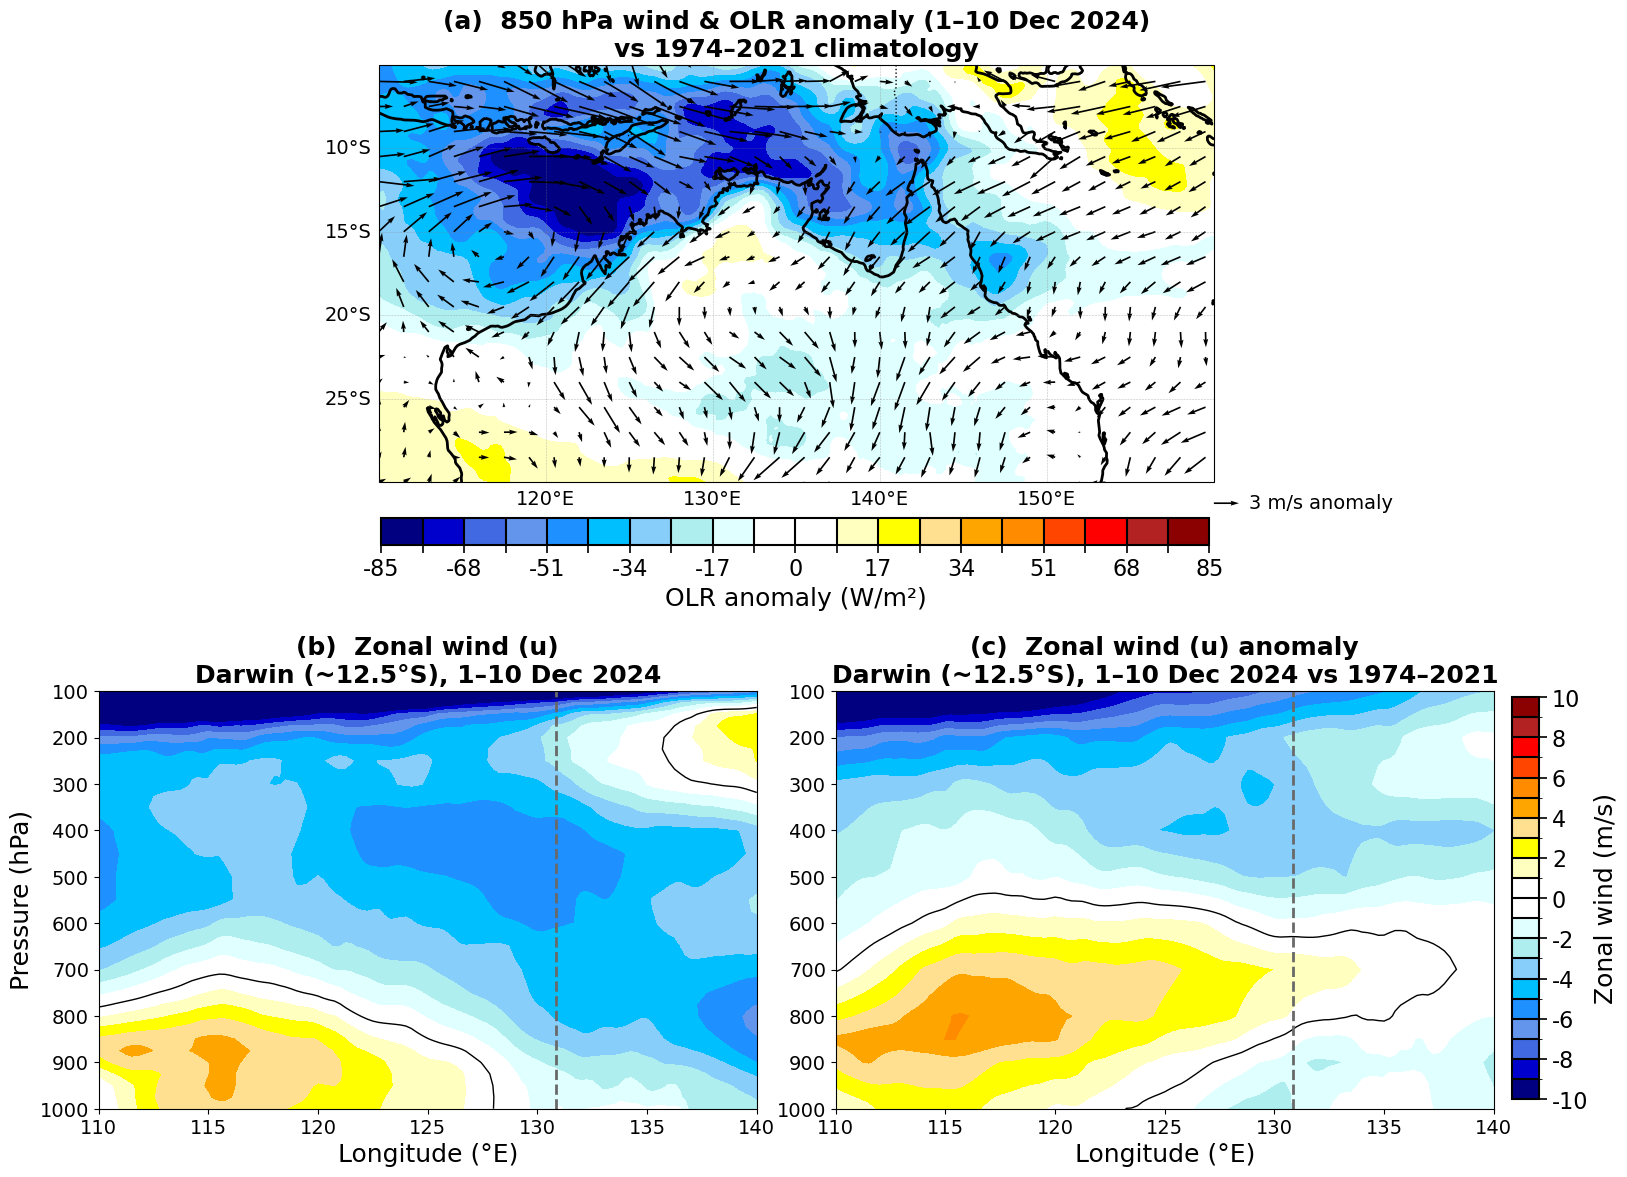

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib as mpl
import glob
import os
import logging
logging.getLogger("flox").setLevel(logging.WARNING)

# =====================================================
# FILE PATHS CONFIGURATION
# =====================================================
lat_darwin = -12.4637
lon_min, lon_max = 110, 155
start_date, end_date = "2024-12-01", "2024-12-10"
years_clim = range(1974, 2022)
levels = [100, 200, 300, 400, 500, 600, 700, 800, 850, 900, 1000]
target_year = 2024

base_dir = "/"
file_2024 = f"{base_dir}/ERA5_U_all_press_levs/{target_year}/u_all_press_levs_5S_15S_110E_140E_era5_daily_{target_year}1201-{target_year}1231.nc"
base_dir_UV = f"{base_dir}/ERA5_U_V_all_press_levs"
u_pattern = base_dir + "/ERA5_U850/{year}/u850_era5_daily_{year}1201-{year}1231.nc"
v_pattern = base_dir + "/ERA5_V850/{year}/v850_era5_daily_{year}1201-{year}1231.nc"
olr_pattern = base_dir + "/ERA5_OLR/{year}/ttr_era5_daily_{year}1201-{year}1231.nc"

# =====================================================
# LOAD & COMPUTE OLR/WIND ANOMALY (TOP ROW)
# =====================================================
time_slice = slice("2024-12-01", "2024-12-10")

u_2024 = xr.open_dataset(u_pattern.format(year=target_year))
v_2024 = xr.open_dataset(v_pattern.format(year=target_year))
olr_2024 = xr.open_dataset(olr_pattern.format(year=target_year))

u_2024_mean = u_2024['u'].sel(time=time_slice).mean(dim="time")
v_2024_mean = v_2024['v'].sel(time=time_slice).mean(dim="time")
olr_2024_mean = olr_2024['ttr'].sel(time=time_slice).mean(dim="time")

u_clim_list, v_clim_list, olr_clim_list = [], [], []
for yr in years_clim:
    try:
        u_ds = xr.open_dataset(u_pattern.format(year=yr))
        v_ds = xr.open_dataset(v_pattern.format(year=yr))
        olr_ds = xr.open_dataset(olr_pattern.format(year=yr))
        u_sel = u_ds['u'].sel(time=slice(f"{yr}-12-01", f"{yr}-12-10")).mean(dim="time")
        v_sel = v_ds['v'].sel(time=slice(f"{yr}-12-01", f"{yr}-12-10")).mean(dim="time")
        olr_sel = olr_ds['ttr'].sel(time=slice(f"{yr}-12-01", f"{yr}-12-10")).mean(dim="time")
        u_clim_list.append(u_sel)
        v_clim_list.append(v_sel)
        olr_clim_list.append(olr_sel)
    except FileNotFoundError:
        continue

u_clim_mean = xr.concat(u_clim_list, dim="year").mean(dim="year")
v_clim_mean = xr.concat(v_clim_list, dim="year").mean(dim="year")
olr_clim_mean = xr.concat(olr_clim_list, dim="year").mean(dim="year")

u_anom850 = u_2024_mean - u_clim_mean
v_anom850 = v_2024_mean - v_clim_mean
olr_anom = olr_2024_mean - olr_clim_mean

# =====================================================
# LOAD & COMPUTE ZONAL WIND CROSS-SECTIONS (BOTTOM ROW)
# =====================================================
ds = xr.open_dataset(file_2024)
u = ds['u'].sel(time=slice(start_date, end_date))
u_darwin = u.sel(latitude=lat_darwin, method='nearest')
u_mean = u_darwin.mean(dim='time').sel(longitude=slice(lon_min, lon_max))

clim_means = []
for lev in levels:
    monthly_files = []
    for year in years_clim:
        path_pattern = f"{base_dir_UV}/{lev}hPa/u/{year}_{year+1}/u{lev}_era5_daily_{year}1201-{year}1231.nc"
        monthly_files.extend(glob.glob(path_pattern))
    if not monthly_files:
        continue
    ds_all = xr.open_mfdataset(monthly_files, combine='by_coords')
    u_clim_dec = ds_all['u'].sel(latitude=lat_darwin, method='nearest')
    u_clim_dec = u_clim_dec.sel(time=u_clim_dec['time'].dt.day <= 10)
    u_clim_mean = u_clim_dec.groupby('time.year').mean(dim='time').mean(dim='year')
    u_clim_mean = u_clim_mean.sel(longitude=slice(lon_min, lon_max))
    u_clim_mean = u_clim_mean.expand_dims(level=[lev])
    clim_means.append(u_clim_mean)

u_clim_all = xr.concat(clim_means, dim='level')
u_anomaly = u_mean - u_clim_all

# =====================================================
# COMBINED FIGURE (1 row top, 2 row bottom)
# =====================================================
fig = plt.figure(figsize=(18, 12))

fontsize1 = 18
fontsize2 = 18

# === (TOP) OLR + WIND ANOMALY MAP ===
proj = ccrs.PlateCarree()
extent = [110, 160, -30, -5]
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, projection=proj)
ax1.set_extent(extent, crs=proj)
ax1.add_feature(cfeature.COASTLINE, linewidth=2)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
gl = ax1.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}



colors_olr = [
    "navy", "mediumblue", "royalblue", "cornflowerblue", "dodgerblue", "deepskyblue", "lightskyblue", "paleturquoise", "lightcyan",       
    "white", "white", 
    "#ffffbf", "yellow", "#fee090", "orange", "darkorange", "orangered", "red", "firebrick", "darkred"
]




cmap_olr = mcolors.ListedColormap(colors_olr)
vmin_olr, vmax_olr = -85, 85
levels_olr = np.linspace(vmin_olr, vmax_olr, len(colors_olr) + 1)

cf = ax1.contourf(
    olr_anom['longitude'], olr_anom['latitude'], olr_anom,
    levels=levels_olr, cmap=cmap_olr, extend='both', transform=proj
)

skip = 6
q = ax1.quiver(
    u_anom850['longitude'][::skip], u_anom850['latitude'][::skip],
    u_anom850[::skip, ::skip], v_anom850[::skip, ::skip],
    scale=100, width=0.002, transform=proj, color='k'
)

ax1.quiverkey(q, X=1.03, Y=-0.05, U=3,
             label='3 m/s anomaly', labelpos='E',
             coordinates='axes', fontproperties={'size': 14}) 


ax1.set_title("(a)  850 hPa wind & OLR anomaly (1–10 Dec 2024)\nvs 1974–2021 climatology", fontsize=fontsize1, fontweight='bold')

# === (BOTTOM LEFT) Mean U ===
colors = colors_olr
cmap = mcolors.ListedColormap(colors)
vmin, vmax = -10, 10
c_levels = np.linspace(vmin, vmax, len(colors) + 1)
norm = mpl.colors.BoundaryNorm(c_levels, ncolors=cmap.N, clip=True)

# Darwin’s longitude
lon_darwin = 130.84

ax2 = plt.subplot2grid((2, 2), (1, 0))
cf1 = ax2.contourf(u_mean['longitude'], u_mean['level'], u_mean, cmap=cmap, norm=norm, levels=c_levels, extend='both')
ax2.contour(u_mean['longitude'], u_mean['level'], u_mean, levels=[0], colors='k', linewidths=1)
ax2.invert_yaxis()
ax2.set_ylim(1000, 100)
ax2.set_xlabel("Longitude (°E)", fontsize=fontsize2)
ax2.set_ylabel("Pressure (hPa)", fontsize=fontsize2)
ax2.set_title("(b)  Zonal wind (u)\nDarwin (~12.5°S), 1–10 Dec 2024", fontsize=fontsize1, fontweight='bold')
ax2.tick_params(axis='both', labelsize=14)
ax2.axvline(lon_darwin, color='dimgrey', linestyle='--', linewidth=2, alpha=1)


# === (BOTTOM RIGHT) Anomaly ===
ax3 = plt.subplot2grid((2, 2), (1, 1))
cf2 = ax3.contourf(u_anomaly['longitude'], u_anomaly['level'], u_anomaly, cmap=cmap, norm=norm, levels=c_levels, extend='both')
ax3.contour(u_anomaly['longitude'], u_anomaly['level'], u_anomaly, levels=[0], colors='k', linewidths=1)
ax3.invert_yaxis()
ax3.set_ylim(1000, 100)
ax3.set_xlabel("Longitude (°E)", fontsize=fontsize2)
ax3.set_title("(c)  Zonal wind (u) anomaly\nDarwin (~12.5°S), 1–10 Dec 2024 vs 1974–2021", fontsize=fontsize1, fontweight='bold')
ax3.tick_params(axis='both', labelsize=14)
ax3.axvline(lon_darwin, color='dimgrey', linestyle='--', linewidth=2, alpha=1)


# === Shared colorbar (for bottom row) ===
cbaxes = fig.add_axes([0.91, 0.088, 0.015, 0.335])
my_cmap, my_norm = mpl.colors.from_levels_and_colors(c_levels, colors, extend='neither')
cbar = mpl.colorbar.ColorbarBase(cbaxes, cmap=my_cmap, norm=my_norm, boundaries=c_levels, orientation='vertical', drawedges=True)
ticks = np.arange(vmin, vmax+1, 2)
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels([f"{t:.0f}" for t in ticks])
cbar.set_label("Zonal wind (m/s)", fontsize=fontsize2)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1.5)
cbar.dividers.set_color('black')
cbar.dividers.set_linewidth(1.5)
cbar.ax.tick_params(labelsize=16, length=12, width=1.2, direction='inout')


# === Horizontal colorbar for top map ===
cbaxes2 = fig.add_axes([0.282, 0.55, 0.46, 0.022])

my_cmap2, my_norm2 = mpl.colors.from_levels_and_colors(levels_olr, colors_olr, extend='neither')
cbar2 = mpl.colorbar.ColorbarBase(cbaxes2, cmap=my_cmap2, norm=my_norm2, boundaries=levels_olr, orientation='horizontal', drawedges=True)

ticks = np.arange(-85, 86, 1)
cbar2.set_ticks(ticks)
cbar2.ax.set_xticklabels([f"{t:.0f}" for t in ticks])
cbar2.set_label("OLR anomaly (W/m²)", fontsize=fontsize2)
cbar2.set_ticks(levels_olr)
cbar2.outline.set_edgecolor('black')
cbar2.outline.set_linewidth(1.5)
cbar2.dividers.set_color('black')
cbar2.dividers.set_linewidth(1.5)
cbar2.ax.tick_params(labelsize=16, length=12, width=1.2, direction='inout')


plt.subplots_adjust(hspace=0.5, wspace=0.12, top=0.95, bottom=0.08)
plt.show()



